Load the data

In [1]:
import pandas as pd
#import matplotlib.pyplot as plt

#%matplotlib inline

#path = r"C:\Users\Surface\Masterarbeit\data\FEM_Daten\Baseline.xlsx"
path = r"C:\Users\Surface\Masterarbeit\data\Produktionsdaten\WZ_2_Feature_Engineered_vorsortiert_Fynn1.xlsx"

df = pd.read_excel(path)

Data Preprocessing to compare the algorithms, although Decision Trees are not sensitve to feature scalling, they do not use geometric distances


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#target = 'x_Einzug [mm]'
target = 'C1_V01_delta_kan'

# get the numerical features
data_num = df.drop(target, axis = 1)
# get the target values
data_labels = df[target].to_numpy()

# pipeline for preprocessing the data

# Standard Scaler for distribution with 0 mean and 1 std., normal distributed data
data_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
# fit the pipeline to the data and transform it
data_prep = data_pipeline.fit_transform(data_num)

# split the data into training, validation and test sets
# 60% training, 20%, validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(data_prep, data_labels, test_size= 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size= 0.25, random_state=42)
print(data_prep.shape, X_train.shape, X_val.shape, X_test.shape)


(52013, 28) (31207, 28) (10403, 28) (10403, 28)


NGBoost for outputting Probalitiy Distribution instead of single value https://stanfordmlgroup.github.io/ngboost/1-useage.html

In [3]:
# necessary imports for NGBoost
from ngboost import NGBRegressor
from ngboost.scores import LogScore
from ngboost.distns import  Normal
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


Eigene Loop für Grid Search, um mit einem festen Val Set zu arbeiten und dann Early Stopping implementieren, GridSearchCV nur mit Cross Validation und ohne Early Stopping möglich von sklearn

In [4]:
# define the hyperparameter grid    
param_grid = {
    'n_estimators': [ 200, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [ 8, 10, 12, 14],
}

best_score = float('inf')
best_params = None
scores = []
# Loop through all combinations of hyperparameters
for max_depth in param_grid['max_depth']:
    for n_estimators in param_grid['n_estimators']:
        for learning_rate in param_grid['learning_rate']:
            # Create a new NGBRegressor with the current hyperparameters
            ngb = NGBRegressor(
                Dist=Normal, 
                Score=LogScore, 
                Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=max_depth),
                verbose=True, 
                n_estimators=n_estimators, 
                learning_rate=learning_rate
            )
            
            # Fit the model to the training data
            ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val, early_stopping_rounds=20)
            
            # Make predictions on the validation set
            y_preds = ngb.predict(X_val)
            y_dists = ngb.pred_dist(X_val)
            
            # Calculate the mean squared error
            mse = mean_squared_error(y_val, y_preds)
            
            # Calculate R²
            r2 = r2_score(y_val, y_preds)
        
            # Calculate the negative log likelihood
            # Note: The logpdf method returns the log probability density function
            # for the predicted distribution at the given values
            nll = -y_dists.logpdf(y_val).mean()
            
            # Print the results            
            print(f"n_estimators: {n_estimators}, learning_rate: {learning_rate}, max_depth: {max_depth}, MSE: {mse:.3f}, R²: {r2:.3f}, Negative Log Likelihood: {nll:.3f}")
            
            # log the scores
            scores.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'mse': mse,
                'r2': r2,
                'nll': nll
            })
            # Check if this is the best score so far
            if nll < best_score:
                best_score = mse
                best_params = {
                    'n_estimators': n_estimators,
                    'learning_rate': learning_rate,
                    'max_depth': max_depth
                }
     

[iter 0] loss=3.4484 val_loss=3.4442 scale=1.0000 norm=6.1152
[iter 100] loss=2.6788 val_loss=2.7085 scale=2.0000 norm=5.2184
n_estimators: 200, learning_rate: 0.01, max_depth: 8, MSE: 9.531, R²: 0.839, Negative Log Likelihood: 2.454
[iter 0] loss=3.4484 val_loss=3.3945 scale=1.0000 norm=6.1152
== Early stopping achieved.
== Best iteration / VAL67 (val_loss=2.4143)
n_estimators: 200, learning_rate: 0.05, max_depth: 8, MSE: 8.757, R²: 0.852, Negative Log Likelihood: 2.428
[iter 0] loss=3.4484 val_loss=3.3422 scale=1.0000 norm=6.1152
== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.4229)
n_estimators: 200, learning_rate: 0.1, max_depth: 8, MSE: 8.727, R²: 0.852, Negative Log Likelihood: 2.443
[iter 0] loss=3.4484 val_loss=3.4444 scale=1.0000 norm=6.1152
[iter 100] loss=2.6788 val_loss=2.7085 scale=2.0000 norm=5.2184
[iter 200] loss=2.3492 val_loss=2.4532 scale=2.0000 norm=4.4166
[iter 300] loss=2.2247 val_loss=2.4155 scale=2.0000 norm=4.1864
== Early stopping achieved.
=

In [5]:
# get the best parameters, lists for nll, R2 and MSE
# list contains at each position a list element with the score and the parameters dictonary
negLL = []
r2_lst = []
mse = []
for s in scores:
    mse.append([s['mse'],s])
    r2_lst.append([s['r2'],s])
    negLL.append([s['nll'],s])

print(f"best negativ log likelyhood {min(negLL)}")
print(f" best R2-Score {max(r2_lst)}")
print(f" best MSE {min(mse)}")

best negativ log likelyhood [2.4165814871976115, {'n_estimators': 400, 'learning_rate': 0.01, 'max_depth': 8, 'mse': 8.912197403376174, 'r2': 0.8490708886181519, 'nll': 2.4165814871976115}]
 best R2-Score [0.855472460879658, {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 10, 'mse': 8.534191628584471, 'r2': 0.855472460879658, 'nll': 2.5860497945101195}]
 best MSE [8.534191628584471, {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 10, 'mse': 8.534191628584471, 'r2': 0.855472460879658, 'nll': 2.5860497945101195}]


Just one implemantation to test the parameter

In [6]:
# first choice: normal distribution
# default base learner is a depth 3 decision tree
# LogScore for negative log likelihood
# create the model with the best parameters
ngb = NGBRegressor(Dist=Normal, 
                   Score = LogScore, 
                   Base = DecisionTreeRegressor(criterion='friedman_mse' , max_depth=8), 
                   verbose = True, 
                   n_estimators=400, 
                   learning_rate=0.01)
# fit the model to the training data, early stopping on validation set after 20 rounds without improvement
ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val, early_stopping_rounds=20)

[iter 0] loss=3.4484 val_loss=3.4444 scale=1.0000 norm=6.1152
[iter 100] loss=2.6788 val_loss=2.7086 scale=2.0000 norm=5.2184
[iter 200] loss=2.3492 val_loss=2.4531 scale=2.0000 norm=4.4166
[iter 300] loss=2.2247 val_loss=2.4154 scale=2.0000 norm=4.1864
== Early stopping achieved.
== Best iteration / VAL298 (val_loss=2.4152)


NGBRegressor(Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=8),
             n_estimators=400,
             random_state=RandomState(MT19937) at 0x15F7EB23E40)

nll_train: 2.212
Train MSE: 6.817
R² on Train Data: 0.882
nll_test: 2.415
Test MSE: 9.015
R² on Test Data: 0.844
Coverage: 90.00%


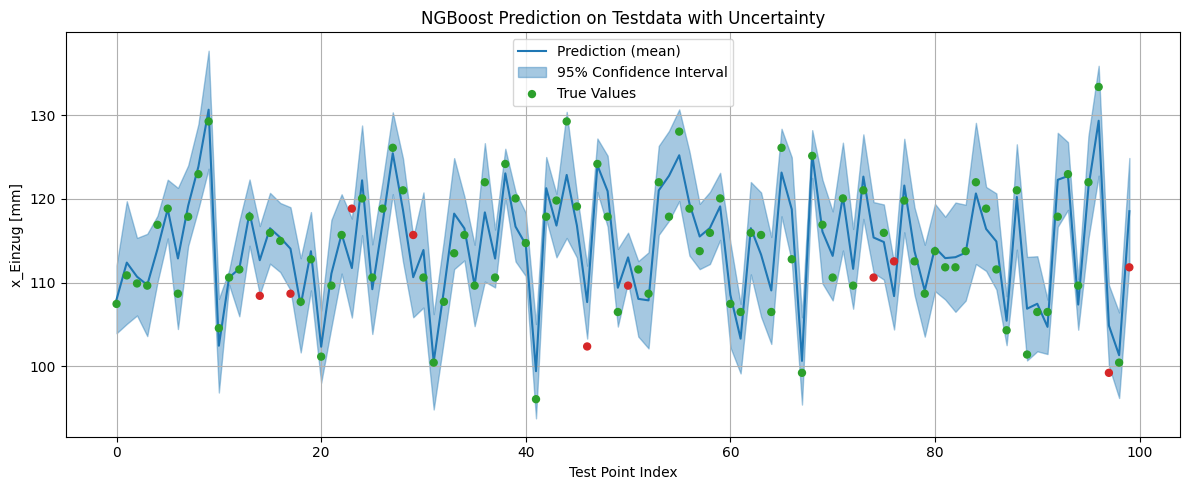

In [7]:
import numpy as np
import matplotlib.pyplot as plt
#import wandb
#wandb.login()

#! handling the train data
# Predicte mean and distribution for train and test data
y_train_preds = ngb.predict(X_train)
y_train_dists = ngb.pred_dist(X_train)

# print the negative log likelihood
print(f"nll_train: {-y_train_dists.logpdf(y_train).mean():.3f}")
# calculate the mean squared error
mse_train = mean_squared_error(y_train, y_train_preds)
print(f"Train MSE: {mse_train:.3f}")
# Calculate R² for the train data
r2_train = r2_score(y_train, y_train_preds)
print(f"R² on Train Data: {r2_train:.3f}")


#! handling the test data
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

# Predict mean and distribution for test data
y_test_preds = ngb.predict(X_test)
y_test_dists = ngb.pred_dist(X_test)
# Extract standard deviation from test predictions
test_stddev = y_test_dists.scale

# print the negative log likelihood
print(f"nll_test: {-y_test_dists.logpdf(y_test).mean():.3f}")
# calculate the mean squared error
mse_train = mean_squared_error(y_test, y_test_preds)
print(f"Test MSE: {mse_train:.3f}")
# Calculate R² for the test data
r2_test = r2_score(y_test, y_test_preds)
print(f"R² on Test Data: {r2_test:.3f}")

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
ngboost_lower = y_test_preds[random_indices] - 2*test_stddev[random_indices]
ngboost_upper = y_test_preds[random_indices] + 2*test_stddev[random_indices]

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test[random_indices] >= ngboost_lower) & (y_test[random_indices] <= ngboost_upper)
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval]

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Plotting the prediction with uncertainty and true values
fig = plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)

# Plot predicted mean
plt.plot(x_axis, y_test_preds[random_indices], label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, ngboost_lower, ngboost_upper,
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, y_test[random_indices], label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("NGBoost Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# wandb.init(project="ngboost-fem-rauschen", config={
#     "n_estimators": 400,
#     "learning_rate": 0.01,
#     "distribution": "Normal",
#     "score": "LogScore",
#     "early_stopping_rounds": 2,
#     })

# wandb.log({"coverage": coverage})
# wandb.log({"R²": r2_test})
# wandb.log({"confidence_interval_plot": wandb.Image(fig)})

Overview on the feature importance

In [ ]:
import seaborn as sns
## Feature importance for loc trees
feature_importance_loc = ngb.feature_importances_[0]

## Feature importance for scale trees
feature_importance_scale = ngb.feature_importances_[1]

features = data_num.columns
#['Matrizenradius [mm ]', 'Stempelkantenradius [mm]', 'Blechdicke [mm]',            'Platinenabmessung [mm]', '1/4 Niederhalterkraft [N]', 'Ziehtiefe [mm]']

df_loc = pd.DataFrame({
                        'feature':features,
                        'importance':feature_importance_loc})\
                        .sort_values('importance',ascending=False)
    
df_scale = pd.DataFrame({
                        'feature':features,
                        'importance':feature_importance_scale})\
                        .sort_values('importance',ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,20))
fig.suptitle("Feature importance plot for distribution parameters", fontsize=15)
sns.barplot(x='importance',y='feature',ax=ax1,data=df_loc, color="skyblue").set_title('mean (loc param)')
sns.barplot(x='importance',y='feature',ax=ax2,data=df_scale, color="skyblue").set_title('std (scale param)')

Gradient Boosting Trees: Decision trees die Fehler korrigieren, Model besteht aus der Summer der einzelenen Modele

In [ ]:
import xgboost

# Initialize the XGBoost regressor
xgb_reg = xgboost.XGBRegressor()

# Fit the model to the training data
xgb_reg.fit(X_train, y_train)

#Get feature importances from the trained model
importances = xgb_reg.feature_importances_
features = ['Matrizenradius [mm ]', 'Stempelkantenradius [mm]', 'Blechdicke [mm]',
            'Platinenabmessung [mm]', '1/4 Niederhalterkraft [N]', 'Ziehtiefe [mm]']

# Create a DataFrame to display feature importance, sorted descending
xgb_feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

#show important features
display(xgb_feat_df)

#Make predictions on train and test set
y_train_pred = xgb_reg.predict(X_train)
y_test_pred = xgb_reg.predict(X_test)

#Calculate R² scores for train and test predictions
r2_train = r2_score(y_train,y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

#Compare R2 Score for the first 10 instances
vergleich_df = pd.DataFrame({
    'True value' : y_test[:10],
    'Prediction' : y_test_pred[:10].flatten(),
    'Difference' : y_test[:10] - y_test_pred[:10].flatten()
 })

#print the result
print(f'\nR² Train: {r2_train:.4f} | R² Test: {r2_test:.4f}')
display(vergleich_df.style.background_gradient(cmap='RdYlGn_r'))